In [ ]:
#note this is taken from: https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py 
#with more discussiion here: https://blog.keras.io/building-autoencoders-in-keras.html

In [33]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow import keras
from tensorflow.keras.layers import Lambda, Input, Dense,Conv2D, MaxPooling2D, Activation, Dropout, Flatten, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
from sklearn import metrics
import h5py
from sklearn import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_15[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_15[0][0]                   
____________________________________________________________________________________________

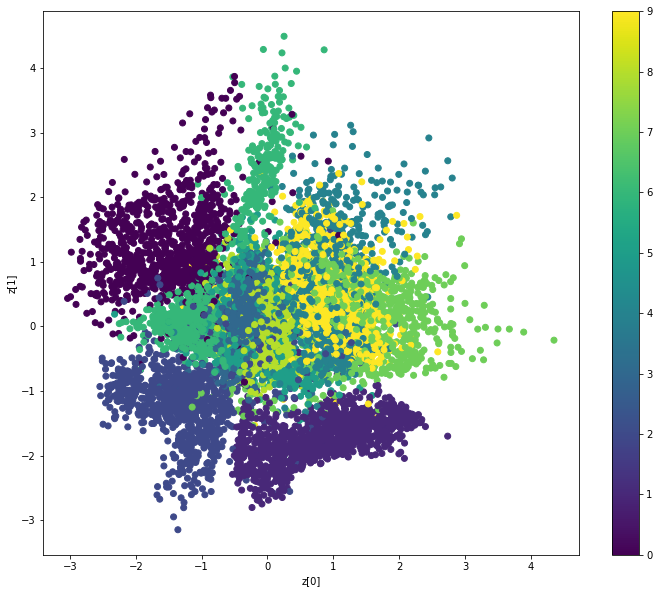

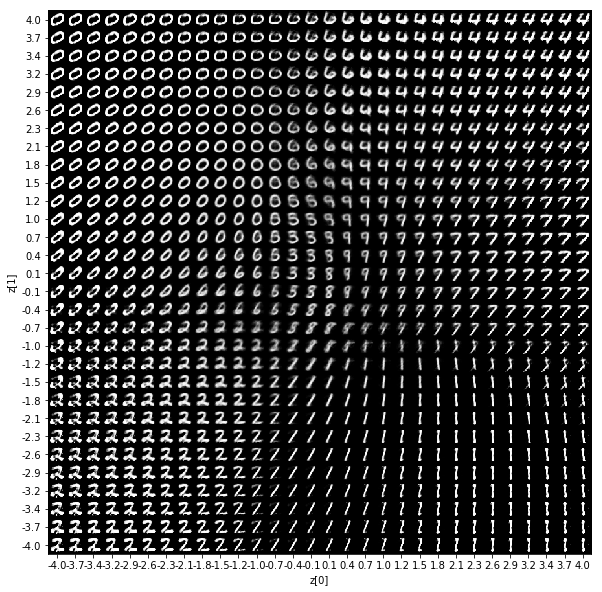

In [9]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''



# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = mse(inputs, outputs)


reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')



    # train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
# vae.save_weights('vae_mlp_mnist.h5')

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")


In [17]:
x_train.shape

(60000, 784)

In [18]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')





new_left_images = []
new_left_labels = []
new_right_images = []
new_right_labels = []


for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append(0)
    new_right_images.append(img)
    new_right_labels.append(1)
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)


split = int(191*0.20)


for idx in np.arange(0,split):
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in np.arange(0,split):
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[:191], new_right_labels[:191],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[:191], new_left_labels[:191],random_state=0)

X_train = np.concatenate((right_img_shuff[:191],left_img_shuff[:191]),axis =0)
Y_train = np.concatenate((right_label_shuff[:191],left_label_shuff[:191]),axis = 0)

split = int(95*0.20)

flipped_right_indices = np.random.choice(np.arange(191,286),split,replace=False)
flipped_left_indices = np.random.choice(np.arange(191,286),split,replace=False)

for idx in np.arange(191,191+split):
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in np.arange(191,191+split):
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[191:286], new_right_labels[191:286],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[191:286], new_left_labels[191:286],random_state=0)


X_test = np.concatenate((right_img_shuff,left_img_shuff),axis = 0)
Y_test = np.concatenate((right_label_shuff,left_label_shuff),axis = 0)

X_train_norm = X_train/X_train.max()
X_test_norm = X_test/X_test.max()
X_train_norm = np.expand_dims(X_train_norm,axis=3)
X_test_norm = np.expand_dims(X_test_norm,axis=3)

X_train_shuff, Y_train_shuff = utils.shuffle(X_train_norm, Y_train,random_state=0)
X_test_shuff, Y_test_shuff = utils.shuffle(X_test_norm, Y_test,random_state=0)

batch_size = 25
seed = 42
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=False,
        vertical_flip = False,
        image_size=(128*128,))

test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow(X_train_shuff, y=Y_train_shuff, batch_size=batch_size,seed=seed)
val_generator = test_datagen.flow(X_test_shuff,y=Y_test_shuff,batch_size=batch_size,seed=seed)

TypeError: __init__() got an unexpected keyword argument 'image_size'

In [ ]:
# MNIST dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# image_size = x_train.shape[1]
# original_dim = image_size * image_size
# x_train = np.reshape(x_train, [-1, original_dim])
# x_test = np.reshape(x_test, [-1, original_dim])
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (128,128)
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(intermediate_dim,(3,3))(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = mse(inputs, outputs)


reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')



    # train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


In [20]:
126/2

63.0

In [22]:
61//2

30

In [23]:
28/2

14.0

In [29]:
input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format

x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x2 = MaxPooling2D((2, 2), padding='same')(x1)
x3 = Conv2D(8, (3, 3), activation='relu', padding='same')(x2)
x4 = MaxPooling2D((2, 2), padding='same')(x3)
x5 = Conv2D(8, (3, 3), activation='relu', padding='same')(x4)
x6 = MaxPooling2D((2, 2), padding='same')(x5)
encoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x6)
encoder = Model(input_img,encoded)

In [30]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 8)         0   

In [36]:

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

encode_input = Input(shape=(16,16,1))
x6 = Conv2D(8, (3, 3), activation='relu', padding='same')(encode_input)
x7 = UpSampling2D((2, 2))(x6)
x8 = Conv2D(8, (3, 3), activation='relu', padding='same')(x7)
x9 = UpSampling2D((2, 2))(x8)
x10 = Conv2D(16, (3, 3), activation='relu',padding='same')(x9)
x11 = UpSampling2D((2, 2))(x10)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x11)
decoder = Model(encode_input,decoded)

In [37]:
decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 8)         80        
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 128, 128, 16)      0   

In [39]:
outputs = decoder(encoder(input_img))
autoencoder = Model(input_img,outputs)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [40]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
model_2 (Model)              (None, 16, 16, 1)         1977      
_________________________________________________________________
model_4 (Model)              (None, 128, 128, 1)       1977      
Total params: 3,954
Trainable params: 3,954
Non-trainable params: 0
_________________________________________________________________


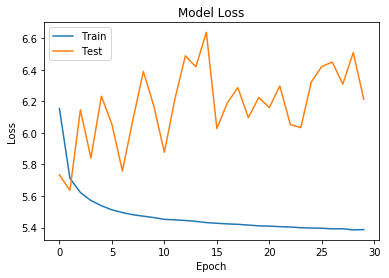

In [41]:
history = h5py.File('savio_nets/autoencoder_v1_history.h5','r')

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [80]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')


for idx,r in enumerate(right_images):
    right_images[idx] = (r-r.min())/(r.max()-r.min())


new_left_images = []
new_right_images = []



for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_right_images.append(img)
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)
X_train = np.concatenate((new_right_images[:191],new_left_images[:191]),axis = 0)
X_test = np.concatenate((new_right_images[191:286],new_left_images[191:286]),axis = 0)
X_val = np.concatenate((new_right_images[286:],new_left_images[286:]),axis = 0)
X_train = np.expand_dims(X_train,axis=3)
X_test = np.expand_dims(X_test,axis=3)
X_val = np.expand_dims(X_val,axis=3)

In [184]:
Y_train = np.concatenate(([[1,0] for i in np.arange(0,191)],[[0,1] for i in np.arange(0,191)]))

In [42]:
autoencoder.load_weights('savio_nets/autoencoder_v1_weights.h5')

In [84]:
pred = autoencoder.predict(X_test)

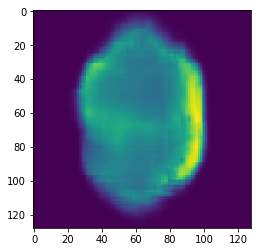

In [85]:
plt.imshow(pred[2,:,:,0])

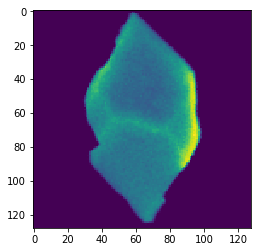

In [86]:
plt.imshow(X_test[2,:,:,0])

In [55]:
weights = h5py.File('savio_nets/autoencoder_v1_weights.h5','r')

In [56]:
list(weights.keys())

['input_1', 'model', 'model_1']

In [60]:
list(weights['model'].keys())

['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3']

In [87]:
pred_flat = encoder.predict(X_train)

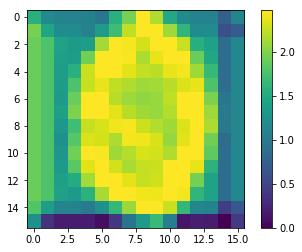

In [206]:
plt.imshow(np.abs(pred_flat[3,:,:,0]-pred_flat[3].max()))
plt.colorbar()

In [92]:
pred_flat.shape

(382, 16, 16, 1)

In [207]:
flat_pred = np.zeros((382,16*16))
for idx,p in enumerate(pred_flat):
    flat_pred[idx] = np.abs(p.flatten()-p.max())

In [94]:
flat_pred.shape

(382, 256)

In [95]:
flat_pred.min()

0.0

In [96]:
flat_pred.max()

2.4680914878845215

In [102]:
from sklearn import decomposition
from sklearn.cluster import KMeans

In [191]:
X_train_flat = np.array([i.flatten() for i in X_train])

In [192]:
X_train_flat.shape

(382, 16384)

In [208]:
pca = decomposition.PCA(n_components=2)
reduced_data = pca.fit_transform(flat_pred)
k = KMeans(init='k-means++',n_clusters=2,n_init=2)
k.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=2, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [209]:
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

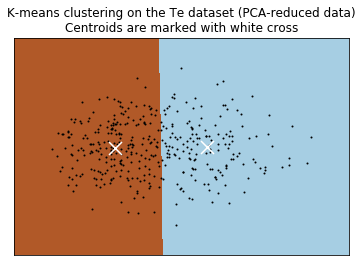

In [210]:
Z = k.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = k.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the Te dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [186]:
Y_train.shape

(382, 2)

In [211]:
metrics.adjusted_rand_score(Y_train[:,0],k.labels_)

-0.0024428967123102698

In [201]:
from skimage import filters

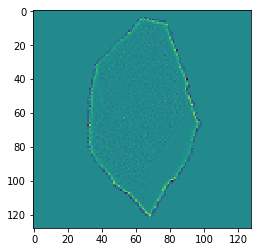

In [214]:
plt.imshow(filters.laplace(X_train[0,:,:,0])*(X_train[0,:,:,0]>0))

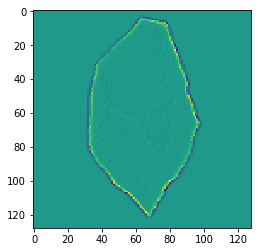

In [216]:
plt.imshow(filters.laplace(filters.median(X_train[0,:,:,0])))

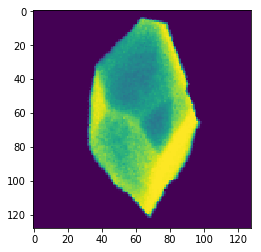

In [204]:
plt.imshow(X_train[0,:,:,0])

In [148]:
from sklearn.datasets import load_digits

In [150]:
X_digits, Y_digits = load_digits(return_X_y=True)

In [151]:
X_digits.shape

(1797, 64)

In [164]:
pca = decomposition.PCA(n_components=2)

In [165]:
reduced_data = pca.fit_transform(X_digits)

In [166]:
reduced_data.shape

(1797, 2)

In [175]:
k.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [170]:
import sklearn

In [171]:
sklearn.__version__

'0.22.1'

In [ ]:
reduced_data = 

In [161]:
pca.components_.shape

(2, 2)

In [147]:
data.shape

(382, 2)

In [174]:
k = KMeans(init='k-means++',n_clusters=10,n_init=10)

In [130]:
data.shape

(382, 2)

In [135]:
flat_pred.shape

(382, 256)

In [145]:
k.fit()

ValueError: The number of features of the initial centers 256 does not match the number of features of the data 2.

In [132]:
data = pca.fit_transform(flat_pred)

In [133]:
data.shape

(382, 2)

In [114]:
reduced_data = data

In [116]:
h=0.02
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [121]:
reduced_data.shape

(382, 2)

In [120]:
Z = k.predict(xx)

ValueError: Incorrect number of features. Got 438 features, expected 256

In [107]:
data.shape

(382, 2)

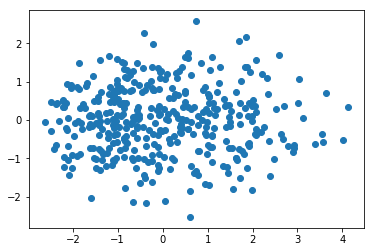

In [109]:
plt.scatter(data[:,0],data[:,1])

In [111]:
pca.explained_variance_ratio_

array([0.24544332, 0.09432121])